### Importing Library

In [1]:
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [2]:
import nltk
nltk.download("stopwords")
import spacy
nlp = spacy.load("en")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RexPC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

### Getting the dataset

In [16]:
# Import dataset
trustpilotDF = pd.read_csv("C:\\Users\RexPC\\Desktop\\Capstone\\TP034717\\dataset\\scraped_text_trust_pilot.csv")

In [17]:
trustpilotDF.head()

,user_id,review_id,user_name,num_of_stars,review_category,review_text,word_count
0,5e859137a9c3cb85b6f71b4f,5e8591403c93ae06dc6ea0d1,ahmed nabil,1,Bad,if i can give them worst experience i will do ...,923
1,5a5b79110000ff000b00d142,5e85774c3c93ae0314584c10,annabelle,1,Bad,i was supposed to go to paris march unfortunat...,1131
2,5e854c843d06210c4775c770,5e854ca03c93ae06dc6e8ec4,yoshi,1,Bad,stayed at jay kollmansberger and robin befus c...,1085
3,5e85376f8a0cd74c20732c28,5e853a463c93ae06dc6e8bb6,randy smith,5,Excellent,we have had multiple problems with airbnb host...,430
4,5e85320c8a0cd7720a732af4,5e8532683c93ae031458400d,trisha campbell,5,Excellent,i have been using airbnb since two thousand an...,642


In [18]:
len(trustpilotDF)

999

### Getting target variable

In [19]:
import lbsa

In [20]:
nrc_lexicon = lbsa.get_lexicon('opinion', language='english', source='nrc')

In [21]:
# refine word_count
trustpilotDF['word_count'] = trustpilotDF['review_text'].apply(lambda x: len(x.split()))

In [22]:
trustpilotDF['positive_sentiment'] = trustpilotDF['review_text'].apply(lambda x: nrc_lexicon.process(x).get('positive'))
trustpilotDF['negative_sentiment'] = trustpilotDF['review_text'].apply(lambda x: nrc_lexicon.process(x).get('negative'))

In [23]:
trustpilotDF['sentiments'] = trustpilotDF['review_text'].apply(lambda x: nrc_lexicon.process(x))
trustpilotDF['target'] = trustpilotDF['sentiments'].apply(lambda x: 1 if x.get('positive') >= x.get('negative') else 0)

In [24]:
trustpilotDF.head()

,user_id,review_id,user_name,num_of_stars,review_category,review_text,word_count,positive_sentiment,negative_sentiment,sentiments,target
0,5e859137a9c3cb85b6f71b4f,5e8591403c93ae06dc6ea0d1,ahmed nabil,1,Bad,if i can give them worst experience i will do ...,171,7,1,"{'positive': 7, 'negative': 1}",1
1,5a5b79110000ff000b00d142,5e85774c3c93ae0314584c10,annabelle,1,Bad,i was supposed to go to paris march unfortunat...,198,18,5,"{'positive': 18, 'negative': 5}",1
2,5e854c843d06210c4775c770,5e854ca03c93ae06dc6e8ec4,yoshi,1,Bad,stayed at jay kollmansberger and robin befus c...,207,8,10,"{'positive': 8, 'negative': 10}",0
3,5e85376f8a0cd74c20732c28,5e853a463c93ae06dc6e8bb6,randy smith,5,Excellent,we have had multiple problems with airbnb host...,81,5,2,"{'positive': 5, 'negative': 2}",1
4,5e85320c8a0cd7720a732af4,5e8532683c93ae031458400d,trisha campbell,5,Excellent,i have been using airbnb since two thousand an...,121,6,1,"{'positive': 6, 'negative': 1}",1


In [25]:
print(trustpilotDF.shape)

(999, 11)


In [26]:
unique_val = pd.DataFrame(trustpilotDF)

In [27]:
unique_val.target.value_counts()

1    649
0    350
Name: target, dtype: int64

In [28]:
str(float("{:.2f}".format(len(trustpilotDF[trustpilotDF.target == 1]) / 999 *100))) + "%"

'64.96%'

In [29]:
str(float("{:.2f}".format(len(trustpilotDF[trustpilotDF.target == 0]) / 999 *100))) + "%"

'35.04%'

### Splitting the dataset into training (80%) and testing (20%)

In [30]:
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [31]:
df = trustpilotDF.drop('target', axis=1)

In [32]:
y = trustpilotDF.target

In [33]:
# Splitting training and testing set to 80 - 20%
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2)

In [34]:
print("training set: ", X_train.shape, y_train.shape)
print("testing set: ", X_test.shape, y_test.shape)

training set:  (799, 10) (799,)
testing set:  (200, 10) (200,)


### Training set

In [35]:
str(float("{:.2f}".format(len(y_train[y_train == 1]) / len(y_train) *100))) + "%"

'65.08%'

In [36]:
str(float("{:.2f}".format(len(y_train[y_train == 0]) / len(y_train) *100))) + "%"

'34.92%'

### Testing set

In [37]:
str(float("{:.2f}".format(len(y_test[y_test == 1]) / len(y_test) *100))) + "%"

'64.5%'

In [38]:
str(float("{:.2f}".format(len(y_test[y_test == 0]) / len(y_test) *100))) + "%"

'35.5%'

### Saving trainign and testing set into pickle 

In [39]:
import pickle
with open('X_train.pkl', 'wb') as f:
    pickle.dump(X_train, f)

In [40]:
with open('y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)

In [41]:
with open('X_test.pkl', 'wb') as f:
    pickle.dump(X_test, f)

In [42]:
with open('y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

### Run Topic Modelling on your corpus (training set) with different numbers of topics 
1. Running LDA, LSA and PLSA model and see if word distribution per topic looks sensible.
2. First approach - Run various models with 10 number of topics and examine the coherence scores
2. Second approach - Effectively grid search to choose the highest coherence

In [43]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['etc','give','go','to','the','this','not','of'])

In [44]:
# Tokenize training set 
def tokenize_word(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
def tokenize_corpus(data):
    data_words = list(tokenize_word(data))
    return data_words

data_words = tokenize_corpus(X_train.review_text.values.tolist())

In [45]:
# Build the biagram and trigram model with gensim Phrases()
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['they', 'scammed', 'my', 'wife', 'out', 'of', 'place', 'to', 'stay', 'and', 'continued', 'to', 'charge', 'our', 'card', 'every', 'three', 'days', 'we', 'did', 'not', 'even', 'stay', 'there', 'lol', 'so', 'sad']


In [46]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    p_stemmer = PorterStemmer()
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [47]:
def preprocess_data(data_words):
    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)

    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)

    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    # python3 -m spacy download en
    nlp = spacy.load('en', disable=['parser', 'ner'])

    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    return data_lemmatized

data_lemmatized = preprocess_data(data_words)
print(preprocess_data(data_words)[:1])

[['wife', 'place', 'stay', 'continued', 'charge', 'card', 'day', 'even', 'stay', 'lol', 'sad']]


In [48]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

# Create Lsa model
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

# Create Lda model
def create_gensim_lda_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    ldamodel = gensim.models.LdaModel(corpus = doc_term_matrix, num_topics=number_of_topics, id2word = dictionary,
                                          random_state=100, 
                                          update_every=1,
                                          chunksize=100,
                                          passes=10,
                                          alpha='auto',
                                          per_word_topics=True)  # train model
    
    print(ldamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return ldamodel

def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(doc_clean, start, stop, step):
    """
    Input   : corpus : Gensim corpus
              start : Min num of topics
              stop : Max num of topics
    purpose : To plot coherence score
    Output  : coherence_values : Coherence values corresponding to the model with respective number of topics
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

### Running LDA, LSA and PLSA model and see if word distribution per topic looks sensible
1. First approach - Run various models with 10 number of topics and examine the coherence scores

In [49]:
number_of_topics=10
words=10

#LSA Model
print("Building LSA Model:")
lsi_model = create_gensim_lsa_model(data_lemmatized,number_of_topics,words)
lsi_model.save('lsi_train.model')

# LDA Model
print("\n")
print("Building LDA Model:")
lda_model = create_gensim_lda_model(data_lemmatized,number_of_topics,words)
lda_model.save('lda_train.model')

Building LSA Model:
[(0, '0.447*"airbnb" + 0.348*"host" + 0.185*"would" + 0.175*"book" + 0.153*"refund" + 0.151*"get" + 0.150*"day" + 0.148*"guest" + 0.138*"stay" + 0.134*"say"'), (1, '-0.359*"airbnb" + 0.288*"review" + -0.288*"cancel" + 0.206*"leave" + -0.197*"book" + 0.166*"guest" + 0.162*"host" + 0.154*"clean" + -0.152*"reservation" + -0.149*"refund"'), (2, '-0.477*"guest" + -0.342*"airbnb" + 0.246*"book" + 0.198*"call" + 0.187*"day" + 0.168*"would" + -0.147*"review" + 0.138*"tell" + -0.109*"fire" + 0.107*"try"'), (3, '0.658*"host" + 0.214*"reservation" + -0.206*"airbnb" + 0.196*"cancel" + -0.158*"get" + -0.124*"refund" + -0.119*"back" + -0.113*"call" + 0.111*"site" + -0.107*"use"'), (4, '-0.386*"guest" + -0.281*"call" + -0.250*"account" + 0.226*"stay" + 0.223*"host" + -0.191*"email" + 0.181*"book" + -0.161*"would" + -0.138*"message" + -0.129*"send"'), (5, '0.371*"guest" + 0.344*"refund" + -0.279*"review" + -0.187*"account" + -0.169*"property" + -0.162*"airbnb" + -0.160*"list" + -0.

In [50]:
pprint(lsi_model.print_topics(-1))

[(0,
  '0.447*"airbnb" + 0.348*"host" + 0.185*"would" + 0.175*"book" + '
  '0.153*"refund" + 0.151*"get" + 0.150*"day" + 0.148*"guest" + 0.138*"stay" + '
  '0.134*"say"'),
 (1,
  '-0.359*"airbnb" + 0.288*"review" + -0.288*"cancel" + 0.206*"leave" + '
  '-0.197*"book" + 0.166*"guest" + 0.162*"host" + 0.154*"clean" + '
  '-0.152*"reservation" + -0.149*"refund"'),
 (2,
  '-0.477*"guest" + -0.342*"airbnb" + 0.246*"book" + 0.198*"call" + '
  '0.187*"day" + 0.168*"would" + -0.147*"review" + 0.138*"tell" + '
  '-0.109*"fire" + 0.107*"try"'),
 (3,
  '0.658*"host" + 0.214*"reservation" + -0.206*"airbnb" + 0.196*"cancel" + '
  '-0.158*"get" + -0.124*"refund" + -0.119*"back" + -0.113*"call" + '
  '0.111*"site" + -0.107*"use"'),
 (4,
  '-0.386*"guest" + -0.281*"call" + -0.250*"account" + 0.226*"stay" + '
  '0.223*"host" + -0.191*"email" + 0.181*"book" + -0.161*"would" + '
  '-0.138*"message" + -0.129*"send"'),
 (5,
  '0.371*"guest" + 0.344*"refund" + -0.279*"review" + -0.187*"account" + '
  '-0.16

In [51]:
pprint(lda_model.print_topics(-1))

[(0,
  '0.035*"clean" + 0.022*"dirty" + 0.014*"bathroom" + 0.014*"review" + '
  '0.012*"door" + 0.012*"guest" + 0.011*"bedroom" + 0.011*"share" + '
  '0.011*"room" + 0.010*"window"'),
 (1,
  '0.022*"inform" + 0.019*"shower" + 0.019*"superhost" + 0.017*"regard" + '
  '0.016*"twice" + 0.016*"little" + 0.015*"fee" + 0.014*"base" + '
  '0.012*"disappoint" + 0.012*"stick"'),
 (2,
  '0.026*"nasty" + 0.022*"proceed" + 0.009*"upstairs" + 0.008*"intrusive" + '
  '0.007*"wire" + 0.002*"belonging" + 0.002*"year_old" + 0.002*"pest" + '
  '0.002*"compliance" + 0.001*"goodness"'),
 (3,
  '0.055*"location" + 0.029*"private" + 0.020*"hot" + 0.018*"rather" + '
  '0.017*"furniture" + 0.016*"rebook" + 0.016*"vrbo" + 0.015*"search" + '
  '0.013*"straight" + 0.013*"liability"'),
 (4,
  '0.028*"item" + 0.025*"hang" + 0.023*"count" + 0.022*"threaten" + '
  '0.022*"suite" + 0.022*"dog" + 0.015*"whatsoever" + 0.013*"guy" + '
  '0.011*"angry" + 0.011*"accurate"'),
 (5,
  '0.030*"airbnb" + 0.025*"host" + 0.015*"

### Examine the coherence scores on the built model

In [52]:
dictionary,doc_term_matrix=prepare_corpus(data_lemmatized)

In [53]:
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix))


Perplexity:  -7.309287057903213


In [54]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score on LDA: ', coherence_lda)


Coherence Score on LDA:  0.48241397257966884


In [55]:
coherence_model_lsi = CoherenceModel(model=lsi_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
coherence_lsi = coherence_model_lsi.get_coherence()
print('\nCoherence Score on LSA: ', coherence_lsi)


Coherence Score on LSA:  0.3667976821682605


### Effectively compute coherence graph with number of topics from 2 to 40

In [56]:
def compute_coherence_values_lda(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list_lda = []
    model_list_lsa = []
    dictionary,doc_term_matrix=prepare_corpus(data_lemmatized)
    for num_topics in range(start, limit, step):
        # generate LSA model
        ldamodel = gensim.models.LdaModel(corpus = doc_term_matrix, num_topics=num_topics, id2word = dictionary,
                                              random_state=100, 
                                              update_every=1,
                                              chunksize=100,
                                              passes=10,
                                              alpha='auto',
                                              per_word_topics=True)  # train model
        
        model_list_lda.append(ldamodel)
        coherencemodel = CoherenceModel(model=ldamodel, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list_lda, coherence_values

In [57]:
model_list_lda, coherence_values_lda = compute_coherence_values_lda(dictionary=dictionary, corpus=doc_term_matrix, texts=data_lemmatized, start=2, limit=40, step=6)

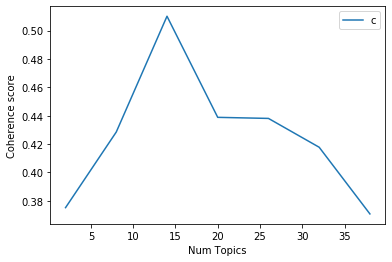

In [58]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values_lda)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [59]:
def compute_coherence_values_lsa(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list_lda = []
    model_list_lsa = []
    dictionary,doc_term_matrix=prepare_corpus(data_lemmatized)
    for num_topics in range(start, limit, step):
        # generate LSA model
        lsamodel = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)

        model_list_lsa.append(lsamodel)
        
        coherencemodel = CoherenceModel(model=lsamodel, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list_lsa, coherence_values

In [60]:
model_list_lsa, coherence_values_lsa = compute_coherence_values_lsa(dictionary=dictionary, corpus=doc_term_matrix, texts=data_lemmatized, start=2, limit=40, step=6)

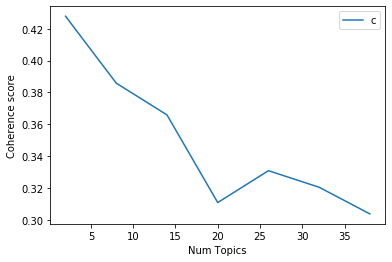

In [61]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values_lsa)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [62]:
for m, cv in zip(x, coherence_values_lda):
    print("LDA - Num Topics =", m, " has Coherence Value of", round(cv, 4))
    
print("\n")
for m, cv in zip(x, coherence_values_lsa):
    print("LSA - Num Topics =", m, " has Coherence Value of", round(cv, 4))

LDA - Num Topics = 2  has Coherence Value of 0.3752
LDA - Num Topics = 8  has Coherence Value of 0.4285
LDA - Num Topics = 14  has Coherence Value of 0.5101
LDA - Num Topics = 20  has Coherence Value of 0.4389
LDA - Num Topics = 26  has Coherence Value of 0.4381
LDA - Num Topics = 32  has Coherence Value of 0.4178
LDA - Num Topics = 38  has Coherence Value of 0.3708


LSA - Num Topics = 2  has Coherence Value of 0.4278
LSA - Num Topics = 8  has Coherence Value of 0.3858
LSA - Num Topics = 14  has Coherence Value of 0.3658
LSA - Num Topics = 20  has Coherence Value of 0.3108
LSA - Num Topics = 26  has Coherence Value of 0.3308
LSA - Num Topics = 32  has Coherence Value of 0.3204
LSA - Num Topics = 38  has Coherence Value of 0.3037


### Selecting LDA with topic 14 (it has the highest coherence and more promosing result)

In [63]:
# Select the model and print the topics
optimal_model_lda = model_list_lda[2]
model_topics = optimal_model_lda.show_topics(formatted=False)
pprint(optimal_model_lda.print_topics(num_words=14))
optimal_model_lda.save('lda_optimal.model')

[(0,
  '0.029*"together" + 0.024*"imagine" + 0.023*"assure" + 0.022*"fraudulent" + '
  '0.022*"procedure" + 0.021*"unknown" + 0.016*"violate" + 0.016*"reality" + '
  '0.016*"polite" + 0.014*"opportunity" + 0.012*"specialist" + 0.011*"unhappy" '
  '+ 0.011*"damage" + 0.010*"utensil"'),
 (1,
  '0.037*"whole" + 0.025*"resolution" + 0.023*"deposit" + 0.023*"manager" + '
  '0.022*"base" + 0.021*"evidence" + 0.020*"nowhere" + 0.019*"hide" + '
  '0.019*"shock" + 0.018*"line" + 0.017*"space" + 0.016*"dog" + 0.015*"submit" '
  '+ 0.015*"difficult"'),
 (2,
  '0.000*"nature" + 0.000*"narrative" + 0.000*"political" + 0.000*"perpetuate" '
  '+ 0.000*"partially" + 0.000*"ounce" + 0.000*"oppose" + 0.000*"noncare" + '
  '0.000*"prime" + 0.000*"implore" + 0.000*"instantly" + 0.000*"ideal" + '
  '0.000*"propose" + 0.000*"incidence"'),
 (3,
  '0.040*"reimburse" + 0.027*"phishing" + 0.022*"model" + 0.021*"cut" + '
  '0.017*"act" + 0.014*"super" + 0.014*"tour" + 0.012*"glad" + '
  '0.011*"identity" + 0.011

In [64]:
optimal_model_lda.print_topics(num_words=14)

[(0,
  '0.029*"together" + 0.024*"imagine" + 0.023*"assure" + 0.022*"fraudulent" + 0.022*"procedure" + 0.021*"unknown" + 0.016*"violate" + 0.016*"reality" + 0.016*"polite" + 0.014*"opportunity" + 0.012*"specialist" + 0.011*"unhappy" + 0.011*"damage" + 0.010*"utensil"'),
 (1,
  '0.037*"whole" + 0.025*"resolution" + 0.023*"deposit" + 0.023*"manager" + 0.022*"base" + 0.021*"evidence" + 0.020*"nowhere" + 0.019*"hide" + 0.019*"shock" + 0.018*"line" + 0.017*"space" + 0.016*"dog" + 0.015*"submit" + 0.015*"difficult"'),
 (2,
  '0.000*"nature" + 0.000*"narrative" + 0.000*"political" + 0.000*"perpetuate" + 0.000*"partially" + 0.000*"ounce" + 0.000*"oppose" + 0.000*"noncare" + 0.000*"prime" + 0.000*"implore" + 0.000*"instantly" + 0.000*"ideal" + 0.000*"propose" + 0.000*"incidence"'),
 (3,
  '0.040*"reimburse" + 0.027*"phishing" + 0.022*"model" + 0.021*"cut" + 0.017*"act" + 0.014*"super" + 0.014*"tour" + 0.012*"glad" + 0.011*"identity" + 0.011*"slow" + 0.011*"expire" + 0.010*"afraid" + 0.010*"drea

In [65]:
for c in optimal_model_lda[doc_term_matrix[5:8]]:
    print("Document Topics      : ", c[0])      # [(Topics, Perc Contrib)]
    print("Word id, Topics      : ", c[1][:3])  # [(Word id, [Topics])]
    print("Phi Values (word id) : ", c[2][:2])  # [(Word id, [(Topic, Phi Value)])]
    print("Word, Topics         : ", [(dictionary[wd], topic) for wd, topic in c[1][:2]])   # [(Word, [Topics])]
    print("Phi Values (word)    : ", [(dictionary[wd], topic) for wd, topic in c[2][:2]])  # [(Word, [(Topic, Phi Value)])]
    print("------------------------------------------------------\n")

Document Topics      :  [(1, 0.10552968), (5, 0.5605564), (6, 0.26635838), (7, 0.025060168), (11, 0.011106474)]
Word id, Topics      :  [(1, [6, 5]), (15, [5, 6]), (55, [5])]
Phi Values (word id) :  [(1, [(5, 0.16585967), (6, 0.83024144)]), (15, [(5, 0.84266335), (6, 0.1573321)])]
Word, Topics         :  [('charge', [6, 5]), ('airbnb', [5, 6])]
Phi Values (word)    :  [('charge', [(5, 0.16585967), (6, 0.83024144)]), ('airbnb', [(5, 0.84266335), (6, 0.1573321)])]
------------------------------------------------------

Document Topics      :  [(5, 0.55747), (6, 0.3111872), (8, 0.097380586)]
Word id, Topics      :  [(3, [5, 6]), (15, [5, 6]), (22, [6, 5])]
Phi Values (word id) :  [(3, [(5, 0.7090689), (6, 0.29091853)]), (15, [(5, 0.81834394), (6, 0.18165155)])]
Word, Topics         :  [('day', [5, 6]), ('airbnb', [5, 6])]
Phi Values (word)    :  [('day', [(5, 0.7090689), (6, 0.29091853)]), ('airbnb', [(5, 0.81834394), (6, 0.18165155)])]
----------------------------------------------------

In [66]:
for c in optimal_model_lda[doc_term_matrix]:
    print("Document Topics      : ", c[0])      # [(Topics, Perc Contrib)]
    print("Word id, Topics      : ", c[1][:3])  # [(Word id, [Topics])]
    print("Phi Values (word id) : ", c[2][:2])  # [(Word id, [(Topic, Phi Value)])]
    print("Word, Topics         : ", [(dictionary[wd], topic) for wd, topic in c[1][:2]])   # [(Word, [Topics])]
    print("Phi Values (word)    : ", [(dictionary[wd], topic) for wd, topic in c[2][:2]])  # [(Word, [(Topic, Phi Value)])]
    print("------------------------------------------------------\n")

Document Topics      :  [(1, 0.012702813), (5, 0.57197285), (6, 0.21145055), (7, 0.102619864), (9, 0.05241585), (11, 0.016242351)]
Word id, Topics      :  [(0, [9]), (1, [6, 5, 9]), (2, [7])]
Phi Values (word id) :  [(0, [(9, 0.9999093)]), (1, [(5, 0.19050789), (6, 0.7210445), (9, 0.08839973)])]
Word, Topics         :  [('card', [9]), ('charge', [6, 5, 9])]
Phi Values (word)    :  [('card', [(9, 0.9999093)]), ('charge', [(5, 0.19050789), (6, 0.7210445), (9, 0.08839973)])]
------------------------------------------------------

Document Topics      :  [(1, 0.03647486), (5, 0.5085439), (6, 0.38455665), (9, 0.010566062), (10, 0.02230249), (11, 0.020988654)]
Word id, Topics      :  [(1, [6, 5, 9]), (4, [5, 6]), (10, [5, 6])]
Phi Values (word id) :  [(1, [(5, 0.32408246), (6, 2.6377208), (9, 0.038058523)]), (4, [(5, 2.9525971), (6, 0.047319822)])]
Word, Topics         :  [('charge', [6, 5, 9]), ('even', [5, 6])]
Phi Values (word)    :  [('charge', [(5, 0.32408246), (6, 2.6377208), (9, 0.038

Phi Values (word)    :  [('stay', [(5, 2.9717486), (6, 0.028216375)]), ('airbnb', [(5, 1.5618993), (6, 0.43809196)])]
------------------------------------------------------

Document Topics      :  [(1, 0.14603846), (5, 0.52383155), (6, 0.31492814)]
Word id, Topics      :  [(1, [6, 5]), (3, [5, 6]), (4, [5, 6])]
Phi Values (word id) :  [(1, [(5, 0.13408324), (6, 0.86459297)]), (3, [(5, 0.69225), (6, 0.30773693)])]
Word, Topics         :  [('charge', [6, 5]), ('day', [5, 6])]
Phi Values (word)    :  [('charge', [(5, 0.13408324), (6, 0.86459297)]), ('day', [(5, 0.69225), (6, 0.30773693)])]
------------------------------------------------------

Document Topics      :  [(1, 0.0392953), (4, 0.03620442), (5, 0.733969), (6, 0.121471964), (9, 0.016080527), (11, 0.018500987), (12, 0.025475392)]
Word id, Topics      :  [(3, [5, 6]), (4, [5]), (6, [5])]
Phi Values (word id) :  [(3, [(5, 1.7887721), (6, 0.2112039)]), (4, [(5, 0.99661976)])]
Word, Topics         :  [('day', [5, 6]), ('even', [5])]

Word, Topics         :  [('even', [5]), ('add', [5, 6])]
Phi Values (word)    :  [('even', [(5, 0.9913254)]), ('add', [(5, 0.75771844), (6, 0.24205159)])]
------------------------------------------------------

Document Topics      :  [(0, 0.022775618), (5, 0.7822051), (6, 0.14930697)]
Word id, Topics      :  [(15, [5, 6]), (23, [5, 6]), (24, [5])]
Phi Values (word id) :  [(15, [(5, 0.93239653), (6, 0.06759982)]), (23, [(5, 0.9546629), (6, 0.045232594)])]
Word, Topics         :  [('airbnb', [5, 6]), ('avoid', [5, 6])]
Phi Values (word)    :  [('airbnb', [(5, 0.93239653), (6, 0.06759982)]), ('avoid', [(5, 0.9546629), (6, 0.045232594)])]
------------------------------------------------------

Document Topics      :  [(5, 0.58146244), (6, 0.29706848), (8, 0.071527354), (11, 0.011075309)]
Word id, Topics      :  [(15, [5, 6]), (25, [5]), (27, [5, 6])]
Phi Values (word id) :  [(15, [(5, 1.6645659), (6, 0.33542538)]), (25, [(5, 0.9990319)])]
Word, Topics         :  [('airbnb', [5, 6]), ('bad

Phi Values (word id) :  [(3, [(5, 1.5451382), (6, 0.45483673)]), (8, [(5, 0.9946272)])]
Word, Topics         :  [('day', [5, 6]), ('stay', [5])]
Phi Values (word)    :  [('day', [(5, 1.5451382), (6, 0.45483673)]), ('stay', [(5, 0.9946272)])]
------------------------------------------------------

Document Topics      :  [(1, 0.017925246), (4, 0.014483069), (5, 0.6980542), (6, 0.13587086), (8, 0.014834111), (11, 0.076966636), (12, 0.028479716)]
Word id, Topics      :  [(6, [5]), (15, [5, 6]), (33, [5])]
Phi Values (word id) :  [(6, [(5, 0.9992465)]), (15, [(5, 1.8600422), (6, 0.13994953)])]
Word, Topics         :  [('place', [5]), ('airbnb', [5, 6])]
Phi Values (word)    :  [('place', [(5, 0.9992465)]), ('airbnb', [(5, 1.8600422), (6, 0.13994953)])]
------------------------------------------------------

Document Topics      :  [(1, 0.01088507), (5, 0.5858869), (6, 0.31847775), (8, 0.03287601), (9, 0.011405929), (11, 0.013917959)]
Word id, Topics      :  [(24, [5, 6]), (27, [6, 5]), (30

Document Topics      :  [(4, 0.02274785), (5, 0.5329927), (6, 0.334946), (9, 0.0718614)]
Word id, Topics      :  [(0, [9]), (8, [5]), (25, [5])]
Phi Values (word id) :  [(0, [(9, 0.99994564)]), (8, [(5, 0.9916048)])]
Word, Topics         :  [('card', [9]), ('stay', [5])]
Phi Values (word)    :  [('card', [(9, 0.99994564)]), ('stay', [(5, 0.9916048)])]
------------------------------------------------------

Document Topics      :  [(1, 0.062486403), (4, 0.020641053), (5, 0.60751647), (6, 0.25523606), (11, 0.028579243)]
Word id, Topics      :  [(8, [5]), (15, [5, 6]), (27, [5, 6])]
Phi Values (word id) :  [(8, [(5, 0.9944243)]), (15, [(5, 0.85812795), (6, 0.1418676)])]
Word, Topics         :  [('stay', [5]), ('airbnb', [5, 6])]
Phi Values (word)    :  [('stay', [(5, 0.9944243)]), ('airbnb', [(5, 0.85812795), (6, 0.1418676)])]
------------------------------------------------------

Document Topics      :  [(1, 0.05654221), (5, 0.69786435), (6, 0.15105632), (11, 0.011695584), (12, 0.052164

Document Topics      :  [(5, 0.58252543), (6, 0.33960372), (7, 0.025646003), (11, 0.011332586)]
Word id, Topics      :  [(3, [5, 6]), (15, [5, 6]), (27, [6, 5])]
Phi Values (word id) :  [(3, [(5, 0.7007936), (6, 0.29919446)]), (15, [(5, 0.81235415), (6, 0.18764158)])]
Word, Topics         :  [('day', [5, 6]), ('airbnb', [5, 6])]
Phi Values (word)    :  [('day', [(5, 0.7007936), (6, 0.29919446)]), ('airbnb', [(5, 0.81235415), (6, 0.18764158)])]
------------------------------------------------------

Document Topics      :  [(5, 0.50731444), (6, 0.3477761), (9, 0.013239197), (10, 0.06794807), (11, 0.035556514)]
Word id, Topics      :  [(10, [5, 6]), (33, [5]), (47, [6, 5])]
Phi Values (word id) :  [(10, [(5, 0.6547315), (6, 0.34502205)]), (33, [(5, 0.9999446)])]
Word, Topics         :  [('add', [5, 6]), ('care', [5])]
Phi Values (word)    :  [('add', [(5, 0.6547315), (6, 0.34502205)]), ('care', [(5, 0.9999446)])]
------------------------------------------------------

Document Topics    

Phi Values (word id) :  [(15, [(5, 0.8200434), (6, 0.17995149)]), (48, [(5, 0.29510328), (6, 0.70486885)])]
Word, Topics         :  [('airbnb', [5, 6]), ('customer', [6, 5])]
Phi Values (word)    :  [('airbnb', [(5, 0.8200434), (6, 0.17995149)]), ('customer', [(5, 0.29510328), (6, 0.70486885)])]
------------------------------------------------------

Document Topics      :  [(4, 0.023212994), (5, 0.6408249), (6, 0.26852727), (9, 0.021592617), (11, 0.017758373)]
Word id, Topics      :  [(3, [5, 6]), (15, [5, 6]), (25, [5])]
Phi Values (word id) :  [(3, [(5, 0.7666854), (6, 0.23330276)]), (15, [(5, 0.8586344), (6, 0.1413615)])]
Word, Topics         :  [('day', [5, 6]), ('airbnb', [5, 6])]
Phi Values (word)    :  [('day', [(5, 0.7666854), (6, 0.23330276)]), ('airbnb', [(5, 0.8586344), (6, 0.1413615)])]
------------------------------------------------------

Document Topics      :  [(5, 0.7441901), (6, 0.19054587), (11, 0.022902848)]
Word id, Topics      :  [(40, [5, 6]), (42, [5, 6]), (61

Phi Values (word)    :  [('case', [(5, 0.27909145), (6, 0.72086)]), ('host', [(5, 0.9196103), (6, 0.0803842)])]
------------------------------------------------------

Document Topics      :  [(5, 0.51225126), (6, 0.42324874), (8, 0.011632839), (12, 0.022142839), (13, 0.011000666)]
Word id, Topics      :  [(1, [6, 5]), (3, [5, 6]), (12, [5])]
Phi Values (word id) :  [(1, [(5, 0.20201778), (6, 1.7952511)]), (3, [(5, 1.240177), (6, 0.759799)])]
Word, Topics         :  [('charge', [6, 5]), ('day', [5, 6])]
Phi Values (word)    :  [('charge', [(5, 0.20201778), (6, 1.7952511)]), ('day', [(5, 1.240177), (6, 0.759799)])]
------------------------------------------------------

Document Topics      :  [(4, 0.015080238), (5, 0.6885701), (6, 0.15469204), (10, 0.03005025), (11, 0.06356102), (12, 0.02964407)]
Word id, Topics      :  [(14, [5]), (20, [6, 5]), (30, [6, 5])]
Phi Values (word id) :  [(14, [(5, 0.9998785)]), (20, [(5, 0.15925963), (6, 0.84059006)])]
Word, Topics         :  [('agree', [5

Word, Topics         :  [('airbnb', [5, 6]), ('say', [5, 6])]
Phi Values (word)    :  [('airbnb', [(5, 1.6503047), (6, 0.34968567)]), ('say', [(5, 0.52760017), (6, 0.47238484)])]
------------------------------------------------------

Document Topics      :  [(0, 0.022868529), (5, 0.44860253), (6, 0.46267346), (10, 0.024955887)]
Word id, Topics      :  [(4, [5, 6]), (27, [6, 5]), (28, [6, 5])]
Phi Values (word id) :  [(4, [(5, 0.9785353), (6, 0.021433285)]), (27, [(5, 0.33869928), (6, 0.66129285)])]
Word, Topics         :  [('even', [5, 6]), ('book', [6, 5])]
Phi Values (word)    :  [('even', [(5, 0.9785353), (6, 0.021433285)]), ('book', [(5, 0.33869928), (6, 0.66129285)])]
------------------------------------------------------

Document Topics      :  [(0, 0.018443614), (5, 0.5757272), (6, 0.26644057), (9, 0.034089725), (11, 0.08793543)]
Word id, Topics      :  [(6, [5]), (15, [5, 6]), (24, [5, 6])]
Phi Values (word id) :  [(6, [(5, 0.99816966)]), (15, [(5, 1.6882548), (6, 0.3117362)]

Phi Values (word)    :  [('airbnb', [(5, 0.8043412), (6, 0.19565453)]), ('cancellation', [(6, 0.9943076)])]
------------------------------------------------------

Document Topics      :  [(1, 0.01088076), (5, 0.528156), (6, 0.31415227), (8, 0.019955467), (11, 0.09430489), (12, 0.020012263)]
Word id, Topics      :  [(3, [5, 6]), (4, [5, 6]), (6, [5])]
Phi Values (word id) :  [(3, [(5, 2.7771773), (6, 1.2227707)]), (4, [(5, 0.98755425), (6, 0.012419055)])]
Word, Topics         :  [('day', [5, 6]), ('even', [5, 6])]
Phi Values (word)    :  [('day', [(5, 2.7771773), (6, 1.2227707)]), ('even', [(5, 0.98755425), (6, 0.012419055)])]
------------------------------------------------------

Document Topics      :  [(5, 0.6046151), (6, 0.16405943), (9, 0.065244235), (11, 0.1442321)]
Word id, Topics      :  [(3, [5, 6]), (4, [5]), (25, [5])]
Phi Values (word id) :  [(3, [(5, 0.83685815), (6, 0.16312818)]), (4, [(5, 0.9944399)])]
Word, Topics         :  [('day', [5, 6]), ('even', [5])]
Phi Values 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[(8, [(5, 0.9949598)]), (54, [(1, 0.999771)])]
Word, Topics         :  [('stay', [5]), ('dispute', [1])]
Phi Values (word)    :  [('stay', [(5, 0.9949598)]), ('dispute', [(1, 0.999771)])]
------------------------------------------------------

Document Topics      :  [(5, 0.46003732), (6, 0.4266215), (10, 0.039690886), (11, 0.044379845)]
Word id, Topics      :  [(6, [5]), (15, [5, 6]), (22, [6, 5])]
Phi Values (word id) :  [(6, [(5, 1.9926596)]), (15, [(5, 0.7287377), (6, 0.2712574)])]
Word, Topics         :  [('place', [5]), ('airbnb', [5, 6])]
Phi Values (word)    :  [('place', [(5, 1.9926596)]), ('airbnb', [(5, 0.7287377), (6, 0.2712574)])]
------------------------------------------------------

Document Topics      :  [(5, 0.7127269), (6, 0.2457307)]
Word id, Topics      :  [(3, [5, 6]), (8, [5]), (15, [5, 6])]
Phi Values (word id) :  [(3, [(5, 0.7998815), (6, 0.20010728)]), (8, [(5, 1.9908603)])]
Word, Topics         :  [('day', [5, 6]), ('stay', [5])]
Phi Values (word)    :  [('d

Phi Values (word id) :  [(3, [(5, 1.6849009), (6, 0.31507725)]), (4, [(5, 0.9946686)])]
Word, Topics         :  [('day', [5, 6]), ('even', [5])]
Phi Values (word)    :  [('day', [(5, 1.6849009), (6, 0.31507725)]), ('even', [(5, 0.9946686)])]
------------------------------------------------------

Document Topics      :  [(5, 0.64690715), (6, 0.25938264), (8, 0.017188411), (10, 0.047051016)]
Word id, Topics      :  [(3, [5, 6]), (15, [5, 6]), (27, [5, 6])]
Phi Values (word id) :  [(3, [(5, 1.5470448), (6, 0.4529317)]), (15, [(5, 2.5897725), (6, 0.41021517)])]
Word, Topics         :  [('day', [5, 6]), ('airbnb', [5, 6])]
Phi Values (word)    :  [('day', [(5, 1.5470448), (6, 0.4529317)]), ('airbnb', [(5, 2.5897725), (6, 0.41021517)])]
------------------------------------------------------

Document Topics      :  [(5, 0.41148937), (6, 0.49925417), (8, 0.023025911), (10, 0.024444288), (11, 0.012058949)]
Word id, Topics      :  [(15, [5, 6]), (28, [6, 5]), (48, [6, 5])]
Phi Values (word id)

Document Topics      :  [(1, 0.024366306), (5, 0.7329218), (6, 0.14800902), (9, 0.022169277), (10, 0.035277132), (13, 0.017254537)]
Word id, Topics      :  [(15, [5, 6]), (25, [5]), (26, [5])]
Phi Values (word id) :  [(15, [(5, 3.7115486), (6, 0.2884359)]), (25, [(5, 0.9996165)])]
Word, Topics         :  [('airbnb', [5, 6]), ('bad', [5])]
Phi Values (word)    :  [('airbnb', [(5, 3.7115486), (6, 0.2884359)]), ('bad', [(5, 0.9996165)])]
------------------------------------------------------

Document Topics      :  [(3, 0.013647884), (5, 0.5900093), (6, 0.3541312), (8, 0.014754363)]
Word id, Topics      :  [(3, [5, 6]), (8, [5, 6]), (15, [5, 6])]
Phi Values (word id) :  [(3, [(5, 1.38624), (6, 0.61373675)]), (8, [(5, 2.975838), (6, 0.024129603)])]
Word, Topics         :  [('day', [5, 6]), ('stay', [5, 6])]
Phi Values (word)    :  [('day', [(5, 1.38624), (6, 0.61373675)]), ('stay', [(5, 2.975838), (6, 0.024129603)])]
------------------------------------------------------

Document Topics 

Document Topics      :  [(1, 0.04283074), (5, 0.5418677), (6, 0.337409), (10, 0.011758437), (11, 0.043999843), (12, 0.011472998)]
Word id, Topics      :  [(3, [5, 6]), (6, [5]), (8, [5, 6])]
Phi Values (word id) :  [(3, [(5, 1.3696842), (6, 0.63029104)]), (6, [(5, 0.9975385)])]
Word, Topics         :  [('day', [5, 6]), ('place', [5])]
Phi Values (word)    :  [('day', [(5, 1.3696842), (6, 0.63029104)]), ('place', [(5, 0.9975385)])]
------------------------------------------------------

Document Topics      :  [(5, 0.47104663), (6, 0.23033619), (9, 0.1269266), (11, 0.14507702)]
Word id, Topics      :  [(1, [6, 9, 5]), (8, [5]), (15, [5, 6])]
Phi Values (word id) :  [(1, [(5, 0.3776077), (6, 1.9496167), (9, 0.67266256)]), (8, [(5, 0.99350953)])]
Word, Topics         :  [('charge', [6, 9, 5]), ('stay', [5])]
Phi Values (word)    :  [('charge', [(5, 0.3776077), (6, 1.9496167), (9, 0.67266256)]), ('stay', [(5, 0.99350953)])]
------------------------------------------------------

Document T

Document Topics      :  [(5, 0.5412175), (6, 0.32032222), (9, 0.011658759), (10, 0.056946628), (11, 0.038086433)]
Word id, Topics      :  [(4, [5, 6]), (8, [5]), (62, [5, 6, 9])]
Phi Values (word id) :  [(4, [(5, 0.9877716), (6, 0.012202115)]), (8, [(5, 0.99212915)])]
Word, Topics         :  [('even', [5, 6]), ('stay', [5])]
Phi Values (word)    :  [('even', [(5, 0.9877716), (6, 0.012202115)]), ('stay', [(5, 0.99212915)])]
------------------------------------------------------

Document Topics      :  [(0, 0.03231333), (5, 0.6298949), (6, 0.2547859), (10, 0.04297247), (11, 0.019801388)]
Word id, Topics      :  [(3, [5, 6]), (4, [5]), (8, [5, 6])]
Phi Values (word id) :  [(3, [(5, 0.77168465), (6, 0.22830322)]), (4, [(5, 0.9915984)])]
Word, Topics         :  [('day', [5, 6]), ('even', [5])]
Phi Values (word)    :  [('day', [(5, 0.77168465), (6, 0.22830322)]), ('even', [(5, 0.9915984)])]
------------------------------------------------------

Document Topics      :  [(5, 0.63997483), (6,

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Word, Topics         :  [('day', [5, 6]), ('place', [5])]
Phi Values (word)    :  [('day', [(5, 0.82060236), (6, 0.17938548)]), ('place', [(5, 0.9988232)])]
------------------------------------------------------

Document Topics      :  [(5, 0.7243879), (6, 0.19775398), (7, 0.025635038), (11, 0.011332179)]
Word id, Topics      :  [(6, [5]), (8, [5]), (15, [5, 6])]
Phi Values (word id) :  [(6, [(5, 2.9968626)]), (8, [(5, 1.9928954)])]
Word, Topics         :  [('place', [5]), ('stay', [5])]
Phi Values (word)    :  [('place', [(5, 2.9968626)]), ('stay', [(5, 1.9928954)])]
------------------------------------------------------

Document Topics      :  [(1, 0.038768407), (5, 0.35254523), (6, 0.5048457), (9, 0.03107492), (10, 0.022821838), (11, 0.022947777)]
Word id, Topics      :  [(0, [9]), (1, [6, 5, 9]), (3, [6, 5])]
Phi Values (word id) :  [(0, [(9, 7.9990954)]), (1, [(5, 0.35201767), (6, 5.43769), (9, 0.21006759)])]
Word, Topics         :  [('card', [9]), ('charge', [6, 5, 9])]
Phi Val

Phi Values (word)    :  [('charge', [(5, 0.15209596), (6, 0.8470911)]), ('day', [(5, 2.167659), (6, 0.83230555)])]
------------------------------------------------------

Document Topics      :  [(1, 0.019684445), (5, 0.6779588), (6, 0.15624386), (7, 0.025670025), (11, 0.07589776), (12, 0.026468394)]
Word id, Topics      :  [(1, [6, 5]), (3, [5, 6]), (4, [5])]
Phi Values (word id) :  [(1, [(5, 0.29067424), (6, 0.70730436)]), (3, [(5, 0.85633236), (6, 0.14365527)])]
Word, Topics         :  [('charge', [6, 5]), ('day', [5, 6])]
Phi Values (word)    :  [('charge', [(5, 0.29067424), (6, 0.70730436)]), ('day', [(5, 0.85633236), (6, 0.14365527)])]
------------------------------------------------------

Document Topics      :  [(5, 0.70116967), (6, 0.19880861), (7, 0.017235313), (8, 0.017982125), (10, 0.019106228), (11, 0.024094451)]
Word id, Topics      :  [(4, [5]), (15, [5, 6]), (18, [6])]
Phi Values (word id) :  [(4, [(5, 0.9941662)]), (15, [(5, 1.8005462), (6, 0.199446)])]
Word, Topics  


Document Topics      :  [(5, 0.5721309), (6, 0.3522099), (9, 0.017482728), (12, 0.034388766)]
Word id, Topics      :  [(3, [5, 6]), (4, [5, 6]), (18, [6])]
Phi Values (word id) :  [(3, [(5, 2.0628471), (6, 0.93711734)]), (4, [(5, 0.98716664), (6, 0.012808658)])]
Word, Topics         :  [('day', [5, 6]), ('even', [5, 6])]
Phi Values (word)    :  [('day', [(5, 2.0628471), (6, 0.93711734)]), ('even', [(5, 0.98716664), (6, 0.012808658)])]
------------------------------------------------------

Document Topics      :  [(1, 0.043906707), (5, 0.58912605), (6, 0.2495232), (11, 0.08523479)]
Word id, Topics      :  [(15, [5, 6]), (30, [6, 5]), (33, [5])]
Phi Values (word id) :  [(15, [(5, 0.85765445), (6, 0.14234108)]), (30, [(5, 0.1184148), (6, 0.881565)])]
Word, Topics         :  [('airbnb', [5, 6]), ('call', [6, 5])]
Phi Values (word)    :  [('airbnb', [(5, 0.85765445), (6, 0.14234108)]), ('call', [(5, 0.1184148), (6, 0.881565)])]
------------------------------------------------------

Docum

Phi Values (word)    :  [('charge', [(5, 0.17110713), (6, 0.82403696)]), ('day', [(5, 0.7507333), (6, 0.24925491)])]
------------------------------------------------------

Document Topics      :  [(1, 0.019760525), (4, 0.015487488), (5, 0.5749798), (6, 0.34997723), (10, 0.016987693)]
Word id, Topics      :  [(15, [5, 6]), (24, [5, 6]), (30, [6, 5])]
Phi Values (word id) :  [(15, [(5, 1.6092896), (6, 0.3907017)]), (24, [(5, 0.97507805), (6, 0.024895528)])]
Word, Topics         :  [('airbnb', [5, 6]), ('back', [5, 6])]
Phi Values (word)    :  [('airbnb', [(5, 1.6092896), (6, 0.3907017)]), ('back', [(5, 0.97507805), (6, 0.024895528)])]
------------------------------------------------------

Document Topics      :  [(1, 0.018658707), (5, 0.73483527), (6, 0.14475201), (10, 0.016542638), (11, 0.027481189), (12, 0.043335266)]
Word id, Topics      :  [(3, [5, 6]), (6, [5]), (8, [5])]
Phi Values (word id) :  [(3, [(5, 0.8764987), (6, 0.12348952)]), (6, [(5, 0.9992375)])]
Word, Topics         :

Phi Values (word)    :  [('place', [(5, 0.9972958)]), ('airbnb', [(5, 0.78514713), (6, 0.21484809)])]
------------------------------------------------------

Document Topics      :  [(0, 0.022841591), (5, 0.65928024), (6, 0.27227435), (11, 0.010018814)]
Word id, Topics      :  [(4, [5]), (6, [5]), (8, [5, 6])]
Phi Values (word id) :  [(4, [(5, 0.99148065)]), (6, [(5, 0.99839044)])]
Word, Topics         :  [('even', [5]), ('place', [5])]
Phi Values (word)    :  [('even', [(5, 0.99148065)]), ('place', [(5, 0.99839044)])]
------------------------------------------------------

Document Topics      :  [(5, 0.6845391), (6, 0.19454114), (9, 0.019709935), (11, 0.05217908), (12, 0.030899217)]
Word id, Topics      :  [(3, [5, 6]), (8, [5, 6]), (15, [5, 6])]
Phi Values (word id) :  [(3, [(5, 0.8293933), (6, 0.17059474)]), (8, [(5, 3.9849508), (6, 0.0150115425)])]
Word, Topics         :  [('day', [5, 6]), ('stay', [5, 6])]
Phi Values (word)    :  [('day', [(5, 0.8293933), (6, 0.17059474)]), ('sta

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[('airbnb', [(5, 0.786509), (6, 0.21348624)]), ('call', [(5, 0.0758957), (6, 0.924089)])]
------------------------------------------------------

Document Topics      :  [(4, 0.034117606), (5, 0.6418092), (6, 0.15719071), (9, 0.024430932), (10, 0.019685037), (11, 0.10463784)]
Word id, Topics      :  [(27, [5, 6]), (40, [5, 6]), (48, [6, 5])]
Phi Values (word id) :  [(27, [(5, 0.6918567), (6, 0.30813208)]), (40, [(5, 0.9125763), (6, 0.087398365)])]
Word, Topics         :  [('book', [5, 6]), ('company', [5, 6])]
Phi Values (word)    :  [('book', [(5, 0.6918567), (6, 0.30813208)]), ('company', [(5, 0.9125763), (6, 0.087398365)])]
------------------------------------------------------

Document Topics      :  [(1, 0.04681396), (5, 0.49004132), (6, 0.28119588), (7, 0.027031127), (11, 0.09671648), (12, 0.03051017)]
Word id, Topics      :  [(8, [5]), (15, [5, 6]), (30, [6, 5])]
Phi Values (word id) :  [(8, [(5, 0.9922896)]), (15, [(5, 4.8813915), (6, 1.1185774)])]
Word, Topics         :  [('s

### saving topics for lexicon sentiment analysis

In [211]:
optimal_model_lda.print_topics(num_words=14)

[(0,
  '0.029*"together" + 0.024*"imagine" + 0.023*"assure" + 0.022*"fraudulent" + 0.022*"procedure" + 0.021*"unknown" + 0.016*"violate" + 0.016*"reality" + 0.016*"polite" + 0.014*"opportunity" + 0.012*"specialist" + 0.011*"unhappy" + 0.011*"damage" + 0.010*"utensil"'),
 (1,
  '0.037*"whole" + 0.025*"resolution" + 0.023*"deposit" + 0.023*"manager" + 0.022*"base" + 0.021*"evidence" + 0.020*"nowhere" + 0.019*"hide" + 0.019*"shock" + 0.018*"line" + 0.017*"space" + 0.016*"dog" + 0.015*"submit" + 0.015*"difficult"'),
 (2,
  '0.000*"nature" + 0.000*"narrative" + 0.000*"political" + 0.000*"perpetuate" + 0.000*"partially" + 0.000*"ounce" + 0.000*"oppose" + 0.000*"noncare" + 0.000*"prime" + 0.000*"implore" + 0.000*"instantly" + 0.000*"ideal" + 0.000*"propose" + 0.000*"incidence"'),
 (3,
  '0.040*"reimburse" + 0.027*"phishing" + 0.022*"model" + 0.021*"cut" + 0.017*"act" + 0.014*"super" + 0.014*"tour" + 0.012*"glad" + 0.011*"identity" + 0.011*"slow" + 0.011*"expire" + 0.010*"afraid" + 0.010*"drea

In [276]:
# Creating Lexicon Csv to store the topic 
import csv
CsvHeader = ['Topic', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6','W7','W8','W9','W10','W11','W12','W13','W14']
with open('trust_pilot_lexicon_sentiment.csv', mode='a', newline='') as file_header:
        head_writer = csv.writer(file_header, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        head_writer.writerow(CsvHeader)

In [277]:
def get_topic_word(lda):
    topic_list = []
    for index, val in enumerate(lda):
        topic_list.append([i.split("*")[1][1:len(i.split("*")[1])-1] for i in lda[index][1].split(" + ")])
    return topic_list 

In [278]:
for word in get_topic_word(optimal_model_lda.print_topics(num_words=14)):
    print(word)
    with open('trust_pilot_lexicon_sentiment.csv', mode='a', newline='') as file_header:
        head_writer = csv.writer(file_header, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        head_writer.writerow(word)

['together', 'imagine', 'assure', 'fraudulent', 'procedure', 'unknown', 'violate', 'reality', 'polite', 'opportunity', 'specialist', 'unhappy', 'damage', 'utensil']
['whole', 'resolution', 'deposit', 'manager', 'base', 'evidence', 'nowhere', 'hide', 'shock', 'line', 'space', 'dog', 'submit', 'difficult']
['nature', 'narrative', 'political', 'perpetuate', 'partially', 'ounce', 'oppose', 'noncare', 'prime', 'implore', 'instantly', 'ideal', 'propose', 'incidence']
['reimburse', 'phishing', 'model', 'cut', 'act', 'super', 'tour', 'glad', 'identity', 'slow', 'expire', 'afraid', 'dreadful', 'scammed']
['guy', 'positive', 'item', 'learn', 'past', 'human', 'tiny', 'video', 'corona', 'prevent', 'general', 'trustpilot', 'basement', 'summer']
['airbnb', 'host', 'stay', 'get', 'refund', 'place', 'review', 'day', 'money', 'guest', 'book', 'use', 'take', 'leave']
['would', 'book', 'cancel', 'call', 'time', 'reservation', 'airbnb', 'try', 'ask', 'account', 'booking', 'say', 'tell', 'email']
['key', '

### Building classifier to training data (seen data) to perform predictive modelling

In [279]:
train_vecs = []
for i in range(len(X_train)):
    top_topics = optimal_model_lda.get_document_topics(doc_term_matrix[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(14)]
    topic_vec.extend([len(X_train.iloc[i].review_text)]) # review word count
    train_vecs.append(topic_vec)

In [281]:
X_train.iloc[2].review_text

'airbnb is not a safe place to host they promise they verify renters and cover them if they damage your property and they do not beware of opening up your home and renting on this platform they do not offer insurance coverage for damages as they promise they allow fake reviews to be left up as a form of extortion from fake renters they are impossible to get a hold of they transfer you from one person to another and never get back to you once you encounter a renter who damages your home violates your rules and steals from your property airbnb block you as a host never have i seen such practices as a host and user of airbnb for over seven years i now understand why the fellow hosts i know no longer open up their homes to renters on this platform airbnb is notorious for this behaviour and insurance companies have caught on to this and are no longer covering homes that are on this platform beware if you think your insurance will cover you if you use airbnb they probably will not and neithe

In [282]:
train_vecs[2]

[0.12360211,
 0.00353288,
 0.00013947603,
 0.00060866063,
 0.0010732808,
 0.75476193,
 0.10032988,
 0.00096633483,
 0.0014140842,
 0.0037019053,
 0.0021088268,
 0.0051405453,
 0.0017899155,
 0.0008301289,
 1202]

In [283]:
X = np.array(train_vecs)

In [284]:
y = np.array(y_train)

In [285]:
len(X)

799

In [286]:
len(y)

799

### Logistic Regression - Predictive model

In [287]:
from sklearn.linear_model import LogisticRegression#create an instance and fit the model 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score

import pandas as pd

from sklearn import datasets, linear_modela
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score # To testify result due to imbalanced problem

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [291]:
kf = KFold(5, shuffle=True, random_state=42)
lr_model_F1, lr_model_accuracy, lr_model_precision, lr_model_recall, lr_model_roc  = [], [], [], [], []
for train_ind, val_ind in kf.split(X, y):
    # Assign CV IDX
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind]
    
    # Scale Data
    scaler = StandardScaler()
    X_train_scale = scaler.fit_transform(X_train)
    X_val_scale = scaler.transform(X_val)
    
    # Logisitic Regression 
    # though, sklearn handles regularization by default, i will implement newton-cg to further handle L2 or no penalty
    logistic_reg_model = LogisticRegression(solver='newton-cg', fit_intercept=True).fit(X_train_scale, y_train)
    logistic_classifier = logistic_reg_model.predict(X_val_scale)
    
    lr_model_F1.append(f1_score(y_val, logistic_classifier, average='binary'))
    lr_model_accuracy.append(metrics.accuracy_score(y_val, logistic_classifier))
    lr_model_precision.append(metrics.precision_score(y_val, logistic_classifier, average='binary'))
    lr_model_recall.append(metrics.recall_score(y_val, logistic_classifier, average='binary'))
    lr_model_roc.append(roc_auc_score(y_val, logistic_classifier))

In [293]:
print("Logistic Regression Accuracy: %.3f (+/- %.3f)" % (np.mean(lr_model_accuracy), np.std(lr_model_accuracy)))
print("Logistic Regression Precision: %.3f (+/- %.3f)" % (np.mean(lr_model_precision), np.std(lr_model_precision)))
print("Logistic Regression Recall: %.3f (+/- %.3f)" % (np.mean(lr_model_recall), np.std(lr_model_recall)))
print("Logistic Regression f1 score: %.3f (+/- %.3f)" % (np.mean(lr_model_F1), np.std(lr_model_F1)))
print("Logistic Regression Roc: %.3f (+/- %.3f)" % (np.mean(lr_model_roc), np.std(lr_model_roc)))


Logistic Regression Accuracy: 0.661 (+/- 0.029)
Logistic Regression Precision: 0.670 (+/- 0.022)
Logistic Regression Recall: 0.944 (+/- 0.015)
Logistic Regression f1 score: 0.784 (+/- 0.019)
Logistic Regression Roc: 0.539 (+/- 0.027)


In [294]:
# Save the Modle to file in the current working directory
Pkl_Filename_1 = "Trustpilot_LogisticRegression_Model.pkl"  

with open(Pkl_Filename_1, 'wb') as file:  
    pickle.dump(logistic_reg_model, file)

### Rerun model with unseen data

In [295]:
data_words_test = tokenize_corpus(X_test.review_text.values.tolist())

In [296]:
# Build the biagram and trigram model with gensim Phrases()
bigram = gensim.models.Phrases(data_words_test, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words_test], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words_test[0]]])

['would', 'give', 'minus', 'if', 'could', 'total', 'rip', 'off', 'booked', 'room', 'by', 'mistake', 'told', 'by', 'host', 'it', 'was', 'easy', 'to', 'cancel', 'and', 'rebook', 'the', 'room', 'wanted', 'two', 'hours', 'later', 'still', 'have', 'room', 'do', 'not', 'want', 'and', 'have', 'paid', 'an', 'extra', 'for', 'the', 'privilege', 'of', 'trying', 'to', 'get', 'the', 'right', 'one', 'which', 'was', 'impossible', 'utterly', 'hacked', 'off', 'and', 'will', 'never', 'use', 'airbnb', 'again', 'ever', 'so', 'yeah', 'if', 'you', 'ever', 'need', 'to', 'cancel', 'do', 'not', 'use', 'this', 'site', 'they', 'charge', 'for', 'cancellations', 'even', 'if', 'it', 'is', 'immediate', 'mine', 'was', 'within', 'five', 'mins', 'of', 'booking', 'they', 'do', 'not', 'show', 'duplicate', 'bookings', 'and', 'if', 'you', 'actually', 'want', 'to', 'speak', 'to', 'airbnb', 'its', 'call', 'charges', 'never', 'ever', 'again', 'you', 'have', 'ruined', 'my', 'trip', 'before', 'it', 'is', 'started']


In [297]:
data_lemmatized_test = preprocess_data(data_words_test)
print(preprocess_data(data_words_test)[:1])

[['would', 'minus', 'could', 'total', 'book', 'room', 'mistake', 'tell', 'host', 'easy', 'cancel', 'rebook', 'room', 'want', 'hour', 'later', 'still', 'room', 'want', 'pay', 'extra', 'privilege', 'try', 'right', 'impossible', 'utterly', 'hack', 'never', 'use', 'airbnb', 'ever', 'ever', 'need', 'cancel', 'use', 'site', 'charge', 'cancellation', 'even', 'immediate', 'min', 'booking', 'show', 'duplicate', 'booking', 'actually', 'want', 'speak', 'airbnb', 'call', 'charge', 'never', 'ever', 'ruin', 'trip', 'start']]


In [298]:
dictionary_test, doc_term_matrix_test=prepare_corpus(data_lemmatized_test)

In [299]:
test_vecs = []
for i in range(len(X_test)):
    top_topics = optimal_model_lda.get_document_topics(doc_term_matrix_test[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(14)]
    topic_vec.extend([len(X_test.iloc[i].review_text)]) # review word count
    test_vecs.append(topic_vec)

In [300]:
test_vecs[2]

[0.08515279,
 0.006356252,
 0.00025093512,
 0.0010950578,
 0.018568128,
 0.5593604,
 0.2625721,
 0.0017385593,
 0.0025441195,
 0.006706432,
 0.04281411,
 0.008127293,
 0.0032202923,
 0.0014935075,
 490]

In [301]:
X2 = np.array(test_vecs)

In [302]:
y2 = np.array(y_test)

In [303]:
len(X2)

200

In [304]:
len(y2)

200

In [305]:
# load built model
with open('Trustpilot_LogisticRegression_Model.pkl', 'rb') as f:
    log_model1 = pickle.load(f)

### Load built classifier with unseen data

In [308]:
kf = KFold(5, shuffle=True, random_state=42)
lr_model_F1, lr_model_accuracy, lr_model_precision, lr_model_recall, lr_model_roc  = [], [], [], [], []

for train_ind, val_ind in kf.split(X2, y2):
    # Assign CV IDX
    X_train, y_train = X2[train_ind], y2[train_ind]
    X_val, y_val = X2[val_ind], y2[val_ind]
    
    # Scale Data
    scaler = StandardScaler()
    X_train_scale = scaler.fit_transform(X_train)
    X_val_scale = scaler.transform(X_val)
    
    # Logisitic Regression 
    # though, sklearn handles regularization by default, i will implement newton-cg to further handle L2 or no penalty
    logistic_reg_model = log_model1.fit(X_train_scale, y_train)
    logistic_classifier = logistic_reg_model.predict(X_val_scale)
    
    lr_model_F1.append(f1_score(y_val, logistic_classifier, average='binary'))
    lr_model_accuracy.append(metrics.accuracy_score(y_val, logistic_classifier))
    lr_model_precision.append(metrics.precision_score(y_val, logistic_classifier, average='binary'))
    lr_model_recall.append(metrics.recall_score(y_val, logistic_classifier, average='binary'))
    lr_model_roc.append(roc_auc_score(y_val, logistic_classifier))

print("Logistic Regression Accuracy: %.3f (+/- %.3f)" % (np.mean(lr_model_accuracy), np.std(lr_model_accuracy)))
print("Logistic Regression Precision: %.3f (+/- %.3f)" % (np.mean(lr_model_precision), np.std(lr_model_precision)))
print("Logistic Regression Recall: %.3f (+/- %.3f)" % (np.mean(lr_model_recall), np.std(lr_model_recall)))
print("Logistic Regression f1 score: %.3f (+/- %.3f)" % (np.mean(lr_model_F1), np.std(lr_model_F1)))
print("Logistic Regression Roc: %.3f (+/- %.3f)" % (np.mean(lr_model_roc), np.std(lr_model_roc)))


Logistic Regression Accuracy: 0.660 (+/- 0.062)
Logistic Regression Precision: 0.703 (+/- 0.062)
Logistic Regression Recall: 0.822 (+/- 0.044)
Logistic Regression f1 score: 0.757 (+/- 0.046)
Logistic Regression Roc: 0.597 (+/- 0.062)
